# The Sims-Flanagan high-fidelity trajectory leg

The Sims-Flanagan trajectory leg {cite:p}`sims` is implemented in `pykep` in the class {class}`pykep.leg.sims_flanagan_hf`. The leg can be used to describe a low-thrust leg with low-fidelity as it assumes Keplerian dynamics
and approximates the continuous thrust via a sequence of continuous, constant thrust arcs (zero-hold). The leg is defined by a starting position $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, an arrival position $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time of flight $T$.

A sequence of throttles $\mathbf u = [u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, u_{x2}, u_{y2}, u_{z2}, ... ]$ define the direction and magnitude of the continuous throttle vector along each segment (i.e. trajectory parts of equal temporal length $\frac Tn$).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.sims_flanagan_hf` efficiently.

We start with some imports:

In [1]:
import pykep as pk
import numpy as np
import time

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

We then define the spacecraft propulsion system and the initial and final state. In this case they are not related to any orbital mechanics and are chosen arbitrarily for the purpose of demostrating the API.

In [2]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000

# Initial state
ms = 1500.0
rs = np.array([1, 0.1, -0.1]) * pk.AU
vs = np.array([0.2, 1, -0.2]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([-1.2, -0.1, 0.1]) * pk.AU
vf = np.array([0.2, -1.023, 0.44]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 10
cut = 0.6
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 324.0 * pk.DAY2SEC

Now we instantiate the leg:

In [3]:
# We are now ready to instantiate a leg
sf = pk.leg.sims_flanagan_hf(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    isp=isp,
    mu=mu,
    cut=cut,
)

And plot the trajectory represented by the random sequence of throttles.

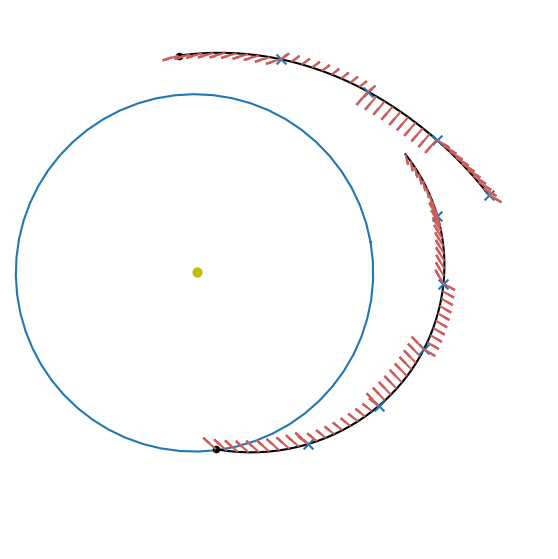

In [4]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Sun Earth and the boundary states
udpla = pk.udpla.jpl_lp(body="EARTH")
earth = pk.planet(udpla)
pk.plot.add_sun(ax, s=40)
pk.plot.add_planet_orbit(ax, earth)
ax.scatter(rs[0] / pk.AU, rs[1] / pk.AU, rs[2] / pk.AU, c="k", s=20)
ax.scatter(rf[0] / pk.AU, rf[1] / pk.AU, rf[2] / pk.AU, c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf, units=pk.AU, N=10, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5
)


# Making the axis nicer
D=1
ax.set_xlim(-D,D)
ax.set_ylim(-D/2,D*3/2)
ax.view_init(90,0)
ax.axis('off');


# The gradients
The main function of this leg is to serve as a fwd-bck shooting blosk in larger optimization problems. The efficent autodiff computation of the gradients of the mismatch and throttle constraints are thus provided for convenience. Indicating the mismatch constraints with $\mathbf{mc}$ and the throttle constraints with $\mathbf{tc}$ we seek the following quntities:

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf x_s} \hskip 1cm (7\times7)
$$

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf x_f} \hskip 1cm (7\times7)
$$

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf u} \hskip 1cm (7\times(3*nseg + 1))
$$

$$
\frac{\partial \mathbf {tc}}{\partial \mathbf u} \hskip 1cm (7\times7)
$$

In [8]:
sf.compute_tc_grad?

Docstring:
compute_tc_grad()

Computes the gradients of the throttles constraints. Indicating the total time of flight with :math:`T` and introducing the augmented throttle vector
:math:`\mathbf u = [u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1} ..., T]` (note the time of flight at the end), this method computes the following gradient:

.. math::
  \frac{\partial \mathbf {tc}}{\partial \mathbf u}

Returns:
    :class:`tuple` [:class:`numpy.ndarray`]: The gradient. Size will be (nseg,nseg*3).

Examples:
  >>> import pykep as pk
  >>> import numpy as np
  >>> sf_hf = pk.leg.sims_flanagan_hf()
  >>  sf_hf.throttles = [0.8]*3
  >>> sf_hf.compute_tc_grad()
Type:      method